# **Automatidata project**
**Course 6 - The Nuts and bolts of machine learning**

You are a data professional in a data analytics firm called Automatidata. Their client, the New York City Taxi & Limousine Commission (New York City TLC), was impressed with the work you have done and has requested that you **build a machine learning model to predict if a customer will not leave a tip**. They want to use the model in an app that will alert taxi drivers to customers who are unlikely to tip, since drivers depend on tips, and the ability to filter out people who don't tip would help increase driver revenue. 

# Course 6 End-of-course project: Build a machine learning model

In this activity, you will practice using tree-based modeling techniques to predict on a binary target class.  
<br/>   

**The purpose** of this model is to find ways to generate more revenue for taxi cab drivers.  
  
**The goal** of this model is to predict whether or not a customer is a generous tipper.  
<br/>  

*This activity has three parts:*

**Part 1:** Ethical considerations 
* Consider the ethical implications of the request 

* Should the objective of the model be adjusted?

**Part 2:** Feature engineering

* Perform feature selection, extraction, and transformation to prepare the data for modeling

**Part 3:** Modeling

* Build the models, evaluate them, and advise on next steps

### **Task 1. Imports and data loading**

Import packages and libraries needed to build and evaluate random forest and XGBoost classification models.

In [1]:
#==> ENTER YOUR CODE HERE

import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import re

In [2]:
# import data
taxi_trips = pd.read_csv('2017_Yellow_Taxi_Trip_Data.csv')

### **Feature engineering**

You have already prepared much of this data and performed exploratory data analysis (EDA) in previous courses. 

In [3]:
# Method chaining, reads like a recipe. Create two new columns and convert them to datetime objects,
# filter the applicable columns, rename columns which aren't clear

taxi_trips = (taxi_trips
 .assign(pick_up = pd.to_datetime(taxi_trips.tpep_pickup_datetime, format='%m/%d/%Y %I:%M:%S %p'))
 .assign(drop_off = pd.to_datetime(taxi_trips.tpep_dropoff_datetime, format='%m/%d/%Y %I:%M:%S %p'))
 .filter(['trip_duration','trip_distance','pick_up'
          ,'drop_off','fare_amount','extra','tip_amount',
          'total_amount','passenger_count','PULocationID',
         'payment_type'])
 .rename(columns={'PULocationID': 'pick_up_location'})
              )

In [4]:
taxi_trips.dtypes

trip_distance              float64
pick_up             datetime64[ns]
drop_off            datetime64[ns]
fare_amount                float64
extra                      float64
tip_amount                 float64
total_amount               float64
passenger_count              int64
pick_up_location             int64
payment_type                 int64
dtype: object

In [5]:
# Creating a new variable called trip duration and assigning it to the dataframe
taxi_trips = (taxi_trips
              .assign(trip_duration = (taxi_trips.drop_off-taxi_trips.pick_up))
              )

In [6]:
# Inspecting our new dataframe
taxi_trips.head()

,trip_distance,pick_up,drop_off,fare_amount,extra,tip_amount,total_amount,passenger_count,pick_up_location,payment_type,trip_duration
0,3.34,2017-03-25 08:55:43,2017-03-25 09:09:47,13.0,0.0,2.76,16.56,6,100,1,0 days 00:14:04
1,1.80,2017-04-11 14:53:28,2017-04-11 15:19:58,16.0,0.0,4.00,20.80,1,186,1,0 days 00:26:30
2,1.00,2017-12-15 07:26:56,2017-12-15 07:34:08,6.5,0.0,1.45,8.75,1,262,1,0 days 00:07:12
3,3.70,2017-05-07 13:17:59,2017-05-07 13:48:14,20.5,0.0,6.39,27.69,1,188,1,0 days 00:30:15
4,4.37,2017-04-15 23:32:20,2017-04-15 23:49:03,16.5,0.5,0.00,17.80,1,4,2,0 days 00:16:43


In [7]:
from datetime import datetime as dt

In [8]:
# Assigning a new column to the dataframe which returns trip duration as a numeric for analysis
# and then convert to minutes.

taxi_trips = (taxi_trips
              .assign(trip_minutes = (taxi_trips.trip_duration.dt.total_seconds()/60).round(2))
              )

# taxi_trips['trip_duration_minutes'] = taxi_trips['trip_duration'].dt.total_seconds() / 60

In [9]:
# Inspecting the changes took place
taxi_trips.head()

,trip_distance,pick_up,drop_off,fare_amount,extra,tip_amount,total_amount,passenger_count,pick_up_location,payment_type,trip_duration,trip_minutes
0,3.34,2017-03-25 08:55:43,2017-03-25 09:09:47,13.0,0.0,2.76,16.56,6,100,1,0 days 00:14:04,14.07
1,1.80,2017-04-11 14:53:28,2017-04-11 15:19:58,16.0,0.0,4.00,20.80,1,186,1,0 days 00:26:30,26.50
2,1.00,2017-12-15 07:26:56,2017-12-15 07:34:08,6.5,0.0,1.45,8.75,1,262,1,0 days 00:07:12,7.20
3,3.70,2017-05-07 13:17:59,2017-05-07 13:48:14,20.5,0.0,6.39,27.69,1,188,1,0 days 00:30:15,30.25
4,4.37,2017-04-15 23:32:20,2017-04-15 23:49:03,16.5,0.5,0.00,17.80,1,4,2,0 days 00:16:43,16.72


You know from your EDA that customers who pay cash generally have a tip amount of $0. To meet the modeling objective, you'll need to sample the data to select only the customers who pay with credit card. 

Use a Boolean mask to filter so your data frame ontains only customers who paid with credit card.

In [10]:
# Boolean mask which filters out customers who pay by credit card only.
# Drop unnecessary columns as we have derived trip duration already.

taxi_trips_1 = (taxi_trips
                .query('payment_type == 1')
#                 .drop(columns=['pick_up','drop_off'])
                )

In [11]:
# Inspecting the changes took place

taxi_trips_1.head()

,trip_distance,pick_up,drop_off,fare_amount,extra,tip_amount,total_amount,passenger_count,pick_up_location,payment_type,trip_duration,trip_minutes
0,3.34,2017-03-25 08:55:43,2017-03-25 09:09:47,13.0,0.0,2.76,16.56,6,100,1,0 days 00:14:04,14.07
1,1.80,2017-04-11 14:53:28,2017-04-11 15:19:58,16.0,0.0,4.00,20.80,1,186,1,0 days 00:26:30,26.50
2,1.00,2017-12-15 07:26:56,2017-12-15 07:34:08,6.5,0.0,1.45,8.75,1,262,1,0 days 00:07:12,7.20
3,3.70,2017-05-07 13:17:59,2017-05-07 13:48:14,20.5,0.0,6.39,27.69,1,188,1,0 days 00:30:15,30.25
5,2.30,2017-03-25 20:34:11,2017-03-25 20:42:11,9.0,0.5,2.06,12.36,6,161,1,0 days 00:08:00,8.00


##### **Target**

Notice that there isn't a column that indicates tip percent, which is what you need to create the target variable. You'll have to engineer it. 

Add a `tip_percent` column to the dataframe by performing the following calculation:  
<br/>  


$$tip\ percent = \frac{tip\ amount}{total\ amount - tip\ amount}$$  


In [12]:
taxi_trips_1 = (taxi_trips_1
                .assign(tip_percent = taxi_trips_1.tip_amount / 
                        (taxi_trips_1.total_amount - taxi_trips_1.tip_amount)
                       )
                )

In [13]:
taxi_trips_1.head()

,trip_distance,pick_up,drop_off,fare_amount,extra,tip_amount,total_amount,passenger_count,pick_up_location,payment_type,trip_duration,trip_minutes,tip_percent
0,3.34,2017-03-25 08:55:43,2017-03-25 09:09:47,13.0,0.0,2.76,16.56,6,100,1,0 days 00:14:04,14.07,0.200000
1,1.80,2017-04-11 14:53:28,2017-04-11 15:19:58,16.0,0.0,4.00,20.80,1,186,1,0 days 00:26:30,26.50,0.238095
2,1.00,2017-12-15 07:26:56,2017-12-15 07:34:08,6.5,0.0,1.45,8.75,1,262,1,0 days 00:07:12,7.20,0.198630
3,3.70,2017-05-07 13:17:59,2017-05-07 13:48:14,20.5,0.0,6.39,27.69,1,188,1,0 days 00:30:15,30.25,0.300000
5,2.30,2017-03-25 20:34:11,2017-03-25 20:42:11,9.0,0.5,2.06,12.36,6,161,1,0 days 00:08:00,8.00,0.200000


Now create another column called `generous`. This will be the target variable. The column should be a binary indicator of whether or not a customer tipped ≥ 20% (0=no, 1=yes).

1. Begin by making the `generous` column a copy of the `tip_percent` column.
2. Reassign the column by converting it to Boolean (True/False).
3. Reassign the column by converting Boolean to binary (1/0).

In [14]:
(taxi_trips_1
 .assign(generous = (taxi_trips_1.tip_percent >= 0.20).astype(int))
)

,trip_distance,pick_up,drop_off,fare_amount,extra,tip_amount,total_amount,passenger_count,pick_up_location,payment_type,trip_duration,trip_minutes,tip_percent,generous
0,3.34,2017-03-25 08:55:43,2017-03-25 09:09:47,13.0,0.0,2.76,16.56,6,100,1,0 days 00:14:04,14.07,0.200000,1
1,1.80,2017-04-11 14:53:28,2017-04-11 15:19:58,16.0,0.0,4.00,20.80,1,186,1,0 days 00:26:30,26.50,0.238095,1
2,1.00,2017-12-15 07:26:56,2017-12-15 07:34:08,6.5,0.0,1.45,8.75,1,262,1,0 days 00:07:12,7.20,0.198630,0
3,3.70,2017-05-07 13:17:59,2017-05-07 13:48:14,20.5,0.0,6.39,27.69,1,188,1,0 days 00:30:15,30.25,0.300000,1
5,2.30,2017-03-25 20:34:11,2017-03-25 20:42:11,9.0,0.5,2.06,12.36,6,161,1,0 days 00:08:00,8.00,0.200000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22692,5.70,2017-07-16 03:22:51,2017-07-16 03:40:52,19.0,0.5,4.05,24.35,1,249,1,0 days 00:18:01,18.02,0.199507,0
22693,0.89,2017-08-10 22:20:04,2017-08-10 22:29:31,7.5,0.5,1.76,10.56,1,229,1,0 days 00:09:27,9.45,0.200000,0
22695,16.71,2017-08-06 16:43:59,2017-08-06 17:24:47,52.0,0.0,14.64,73.20,1,132,1,0 days 00:40:48,40.80,0.250000,1
22697,2.36,2017-07-15 12:56:30,2017-07-15 13:08:26,10.5,0.0,1.70,13.00,1,68,1,0 days 00:11:56,11.93,0.150442,0


In [15]:
# Chaining code here reads like a recipe. Perfect for this task, clear and readable.
# We create a new column with generous tips as greater than 20%
# The next stage is to change the data type, from boolean to integer. This will change True/False to 0/1.
# We're also going to use loc to change the column order.

taxi_trips_1 = (taxi_trips_1
              .assign(generous = (taxi_trips_1.tip_percent >= 0.20)
              .astype(dtype = 'int')
                      )
              )

In [16]:
taxi_trips_1.head()

,trip_distance,pick_up,drop_off,fare_amount,extra,tip_amount,total_amount,passenger_count,pick_up_location,payment_type,trip_duration,trip_minutes,tip_percent,generous
0,3.34,2017-03-25 08:55:43,2017-03-25 09:09:47,13.0,0.0,2.76,16.56,6,100,1,0 days 00:14:04,14.07,0.200000,1
1,1.80,2017-04-11 14:53:28,2017-04-11 15:19:58,16.0,0.0,4.00,20.80,1,186,1,0 days 00:26:30,26.50,0.238095,1
2,1.00,2017-12-15 07:26:56,2017-12-15 07:34:08,6.5,0.0,1.45,8.75,1,262,1,0 days 00:07:12,7.20,0.198630,0
3,3.70,2017-05-07 13:17:59,2017-05-07 13:48:14,20.5,0.0,6.39,27.69,1,188,1,0 days 00:30:15,30.25,0.300000,1
5,2.30,2017-03-25 20:34:11,2017-03-25 20:42:11,9.0,0.5,2.06,12.36,6,161,1,0 days 00:08:00,8.00,0.200000,1


##### **Features**

Which columns are obviously unpredictive of tip percentage? Refer to the data dictionary.

Drop `Unnamed: 0` and `store_and_fwd_flag` columns. Assign the result back to `df1`.


Create a new column called `duration`, which captures the time elapsed from pickup to dropoff.

1.  Subtract `tpep_pickup_datetime` from `tpep_dropoff_datetime` and assign the result to a new column called `duration`.
2.  Convert the `duration` column to seconds. 

In [17]:
# Assign a new column called trip seconds and drop the trip minutes column.
# Drop unnecassary columns

taxi_trips_1 = (taxi_trips_1
                .assign(duration = taxi_trips_1.trip_minutes * 60)
                .drop(columns = ['extra','trip_duration','trip_minutes'])
                )

In [18]:
taxi_trips_1.head()

,trip_distance,pick_up,drop_off,fare_amount,tip_amount,total_amount,passenger_count,pick_up_location,payment_type,tip_percent,generous,duration
0,3.34,2017-03-25 08:55:43,2017-03-25 09:09:47,13.0,2.76,16.56,6,100,1,0.200000,1,844.2
1,1.80,2017-04-11 14:53:28,2017-04-11 15:19:58,16.0,4.00,20.80,1,186,1,0.238095,1,1590.0
2,1.00,2017-12-15 07:26:56,2017-12-15 07:34:08,6.5,1.45,8.75,1,262,1,0.198630,0,432.0
3,3.70,2017-05-07 13:17:59,2017-05-07 13:48:14,20.5,6.39,27.69,1,188,1,0.300000,1,1815.0
5,2.30,2017-03-25 20:34:11,2017-03-25 20:42:11,9.0,2.06,12.36,6,161,1,0.200000,1,480.0


Create a `day`column that contains only the day of the week when each passenger was picked up. Then, convert the values to lowercase.

In [19]:
#==> ENTER YOUR CODE HERE

taxi_trips_1 = taxi_trips_1.assign(day = taxi_trips
                                         .pick_up
                                         .dt.day_name()
                                         .str.lower()
                                   )


<details>
  <summary><h5>HINT</h5></summary>

To convert to day name, use `dt.day_name()` on the column.
</details>

Next, engineer four new columns that represent time of day bins. Each column should contain binary values (0=no, 1=yes) that indicate whether a trip began (picked up) during the following times:

`am_rush` = [06:00&ndash;10:00)  
`daytime` = [10:00&ndash;16:00)  
`pm_rush` = [16:00&ndash;20:00)  
`nighttime` = [20:00&ndash;06:00)

To do this, first create the four columns. For now, each new column should contain the same information: the hour (only) from the `tpep_pickup_datetime` column.

You'll need to write four functions to convert each new column to binary (0/1). Begin with `am_rush`. Complete the function so if the hour is between [06:00–10:00), it returns 1, otherwise, it returns 0.

In [20]:
taxi_trips_1 = taxi_trips_1.assign(
                am_rush = ((taxi_trips_1.pick_up.dt.hour >= 6) & 
                           (taxi_trips_1.pick_up.dt.hour < 10)).astype(int),
    
                daytime = ((taxi_trips_1.pick_up.dt.hour >= 10) & 
                           (taxi_trips_1.pick_up.dt.hour < 16)).astype(int),
    
                pm_rush = ((taxi_trips_1.pick_up.dt.hour >= 16) & 
                           (taxi_trips_1.pick_up.dt.hour < 20)).astype(int),
    
                nighttime = ((taxi_trips_1.pick_up.dt.hour >= 20) | 
                            (taxi_trips_1.pick_up.dt.hour < 6)).astype(int)
                 )

In [21]:
taxi_trips_1.head()

,trip_distance,pick_up,drop_off,fare_amount,tip_amount,total_amount,passenger_count,pick_up_location,payment_type,tip_percent,generous,duration,day,am_rush,daytime,pm_rush,nighttime
0,3.34,2017-03-25 08:55:43,2017-03-25 09:09:47,13.0,2.76,16.56,6,100,1,0.200000,1,844.2,saturday,1,0,0,0
1,1.80,2017-04-11 14:53:28,2017-04-11 15:19:58,16.0,4.00,20.80,1,186,1,0.238095,1,1590.0,tuesday,0,1,0,0
2,1.00,2017-12-15 07:26:56,2017-12-15 07:34:08,6.5,1.45,8.75,1,262,1,0.198630,0,432.0,friday,1,0,0,0
3,3.70,2017-05-07 13:17:59,2017-05-07 13:48:14,20.5,6.39,27.69,1,188,1,0.300000,1,1815.0,sunday,0,1,0,0
5,2.30,2017-03-25 20:34:11,2017-03-25 20:42:11,9.0,2.06,12.36,6,161,1,0.200000,1,480.0,saturday,0,0,0,1


Now, create a `month` column that contains only the abbreviated name of the month when each passenger was picked up, then convert the result to lowercase.

In [22]:
taxi_trips_1 = taxi_trips_1.assign(month = taxi_trips
                                         .pick_up
                                         .dt.strftime('%b')
                                         .str.lower()
                                   )

In [23]:
taxi_trips_1.head()

,trip_distance,pick_up,drop_off,fare_amount,tip_amount,total_amount,passenger_count,pick_up_location,payment_type,tip_percent,generous,duration,day,am_rush,daytime,pm_rush,nighttime,month
0,3.34,2017-03-25 08:55:43,2017-03-25 09:09:47,13.0,2.76,16.56,6,100,1,0.200000,1,844.2,saturday,1,0,0,0,mar
1,1.80,2017-04-11 14:53:28,2017-04-11 15:19:58,16.0,4.00,20.80,1,186,1,0.238095,1,1590.0,tuesday,0,1,0,0,apr
2,1.00,2017-12-15 07:26:56,2017-12-15 07:34:08,6.5,1.45,8.75,1,262,1,0.198630,0,432.0,friday,1,0,0,0,dec
3,3.70,2017-05-07 13:17:59,2017-05-07 13:48:14,20.5,6.39,27.69,1,188,1,0.300000,1,1815.0,sunday,0,1,0,0,may
5,2.30,2017-03-25 20:34:11,2017-03-25 20:42:11,9.0,2.06,12.36,6,161,1,0.200000,1,480.0,saturday,0,0,0,1,mar


Because you have encoded much of the information contained in the pickup and dropoff columns into new columns, you can drop them for modeling. 

1. Drop the `tpep_pickup_datetime` and `tpep_dropoff_datetime` columns and reassign the result back to `df1`.

In [24]:
taxi_trips_1 = (taxi_trips_1
                 .drop(columns = ['pick_up','drop_off','payment_type','day','month','tip_amount'])
                 )

Examine the first five rows of your dataframe.

In [25]:
taxi_trips_1.head()

,trip_distance,fare_amount,total_amount,passenger_count,pick_up_location,tip_percent,generous,duration,am_rush,daytime,pm_rush,nighttime
0,3.34,13.0,16.56,6,100,0.200000,1,844.2,1,0,0,0
1,1.80,16.0,20.80,1,186,0.238095,1,1590.0,0,1,0,0
2,1.00,6.5,8.75,1,262,0.198630,0,432.0,1,0,0,0
3,3.70,20.5,27.69,1,188,0.300000,1,1815.0,0,1,0,0
5,2.30,9.0,12.36,6,161,0.200000,1,480.0,0,0,0,1


Many of the columns are categorical and will need to be dummied (converted to binary). Some of these columns are numeric, but they actually encode categorical information, such as `RatecodeID` and the pickup and dropoff locations. To make these columns recognizable to the `get_dummies()` function as categorical variables, you'll first need to convert them to `type(str)`. 

1. Define a variable called `cols_to_str`, which is a list of the numeric columns that contain categorical information and must be converted to string: `RatecodeID`, `PULocationID`, `DOLocationID`.
2. Write a for loop that converts each column in `cols_to_string` to string.

In [26]:
cols_to_str = ['pick_up_location','passenger_count']

In [27]:
for col in cols_to_str:
    taxi_trips_1[col] = taxi_trips_1[col].astype(str)

In [28]:
taxi_trips_1.head()

,trip_distance,fare_amount,total_amount,passenger_count,pick_up_location,tip_percent,generous,duration,am_rush,daytime,pm_rush,nighttime
0,3.34,13.0,16.56,6,100,0.200000,1,844.2,1,0,0,0
1,1.80,16.0,20.80,1,186,0.238095,1,1590.0,0,1,0,0
2,1.00,6.5,8.75,1,262,0.198630,0,432.0,1,0,0,0
3,3.70,20.5,27.69,1,188,0.300000,1,1815.0,0,1,0,0
5,2.30,9.0,12.36,6,161,0.200000,1,480.0,0,0,0,1


Now convert all the categorical columns to binary.

1. Call `get_dummies()` on the dataframe and assign the results back to a new dataframe called `df2`. Don't use the `drop_first` parameter.


In [29]:
trips = pd.get_dummies(data = taxi_trips_1)

In [30]:
trips.head()

,trip_distance,fare_amount,total_amount,tip_percent,generous,duration,am_rush,daytime,pm_rush,nighttime,...,pick_up_location_80,pick_up_location_82,pick_up_location_87,pick_up_location_88,pick_up_location_90,pick_up_location_91,pick_up_location_92,pick_up_location_93,pick_up_location_95,pick_up_location_97
0,3.34,13.0,16.56,0.200000,1,844.2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.80,16.0,20.80,0.238095,1,1590.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.00,6.5,8.75,0.198630,0,432.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3.70,20.5,27.69,0.300000,1,1815.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2.30,9.0,12.36,0.200000,1,480.0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Finally, drop the columns that are constant or that contain information that would be a proxy for our target variable. For example, `total_amount` contains tip amount, and therefore tip percentage, if used with `fare_amount`. And `mta_tax` is $0.50 99.6% of the time, so it's not adding any predictive signal to the model.

1. Drop the following features: `payment_type`, `mta_tax`, `tip_amount`, `total_amount`, and `tip_percent`. Assign the results to a new dataframe called `df3`. 

In [31]:
trips = (trips
 .drop(columns = ['total_amount','tip_percent'])
 )

##### **Evaluation metric**

Before modeling, you must decide on an evaluation metric. 

1. Examine the class balance of your target variable. 

Approximately 1/3 of the customers in this dataset were "generous" (tipped ≥ 20%). The dataset is imbalanced, but not extremely so. 

To determine a metric, consider the cost of both kinds of model error:
* False positives (the model predicts a tip ≥ 20%, but the customer does not give one)
* False negatives (the model predicts a tip < 20%, but the customer gives more)

False positives are worse for cab drivers, because they would pick up a customer expecting a good tip and then not receiving one.

False negatives are worse for customers, because a cab driver would likely pick up a different customer who was predicted to tip more.

**Since your client represents taxi drivers, use a metric that evaluates false positives. Which metric is this?**

* This metric is the tp/tp+fp. this is the precision.


## PACE: **Construct**

Consider the questions in your PACE Strategy Document to reflect on the Construct stage.

### **Task 3. Modelling**

##### **Split the data**

Now you're ready to model. The only remaining step is to split the data into features/target variable and training/testing data. 

1. Define a variable `y` that isolates the target variable (`generous`).
2. Define a variable `X` that isolates the features.
3. Split the data into training and testing sets. Put 20% of the samples into the test set, stratify the data, and set the random state.

In [32]:
df2 = trips

In [33]:
y = df2.generous

In [34]:
X = df2.drop('generous', axis=1)

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

##### **Random forest**

Begin with using `GridSearchCV` to tune a random forest model.

1. Instantiate the random forest classifier `rf` and set the random state.

2. Create a dictionary `cv_params` of any of the following hyperparameters and their corresponding values to tune. The more you tune, the better your model will fit the data, but the longer it will take. 
 - `max_depth`  
 - `max_features`  
 - `max_samples` 
 - `min_samples_leaf`  
 - `min_samples_split`
 - `n_estimators`  

3. Define a dictionary `scoring` of scoring metrics for GridSearch to capture (precision, recall, F1 score, and accuracy).

4. Instantiate the `GridSearchCV` object `rf_cv1`. Pass to it as arguments:
 - estimator=`rf`
 - param_grid=`cv_params`
 - scoring=`scoring`
 - cv: define the number of you cross-validation folds you want (`cv=_`)
 - refit: indicate which evaluation metric you want to use to select the model (`refit=_`)


**Note:** `refit` should be set to `'precision'`.<font/>
</details>
 


In [36]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

In [37]:
cv_params = {
    'max_depth': [10, 20],
#     'max_features': ['auto', 'sqrt'],
#     'max_samples' : [0.5, 0.8, 1],
#     'min_samples_leaf': [1, 2, 4],
#     'min_samples_split': [2, 5, 10],
#     'n_estimators': [10, 20]
}

In [38]:
scoring = {'precision': 'precision', 'recall': 'recall', 'F1': 'f1', 'accuracy': 'accuracy'}

In [39]:
from sklearn.model_selection import GridSearchCV
rf_cv1 = GridSearchCV(estimator=rf, param_grid=cv_params, scoring=scoring, cv=5, refit='precision')

In [40]:
%%time
rf_cv1.fit(X_train, y_train)

CPU times: total: 11.2 s
Wall time: 11.3 s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [10, 20]}, refit='precision',
             scoring={'F1': 'f1', 'accuracy': 'accuracy',
                      'precision': 'precision', 'recall': 'recall'})

Now fit the model to the training data.

**_Note_**: _The following operation may take over an hour to complete_. Therefore, the cell has been commented out along with code cell #33 (where we pickle the model). To save time, you can skip these cells and continue to execute the cells in order.

If you want, use `pickle` to save your models and read them back in. This can be particularly helpful when performing a search over many possible hyperparameter values.

In [41]:
import pickle

with open('rf_cv1.pkl', 'wb') as f:
    pickle.dump(rf_cv1, f)

Examine the best average score across all the validation folds. 

In [42]:
best_score = rf_cv1.best_score_
print("Best score: ", best_score)

Best score:  0.6486785449482724


Examine the best combination of hyperparameters.

In [43]:
best_params = rf_cv1.best_params_
print("Best parameters: ", best_params)

Best parameters:  {'max_depth': 10}


Use your model to predict on the test data. Assign the results to a variable called `preds`.

In [44]:
# Get the best model found by GridSearchCV
best_model = rf_cv1.best_estimator_

# Use the best model to make predictions on the test set
preds = best_model.predict(X_test)

Complete the below `get_test_scores()` function you will use to output the scores of the model on the test data. 

In [45]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def get_test_scores(model_name:str, preds, y_test_data):
    # Calculate scores
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)
    accuracy = accuracy_score(y_test_data, preds)

    # Create table of results
    scores_dict = {'Model': model_name,
                   'Precision': precision,
                   'Recall': recall,
                   'F1': f1,
                   'Accuracy': accuracy
                  }
    
    table = pd.DataFrame([scores_dict])
    return table

1. Use the `get_test_scores()` function to generate the scores on the test data. Assign the results to `rf_cv2_test_scores`.
2. Call `rf_cv2_test_scores` to output the results.

In [46]:
get_test_scores('Random Forest with Grid Search', preds, y_test)

,Model,Precision,Recall,F1,Accuracy
0,Random Forest with Grid Search,0.651163,0.026316,0.050587,0.655748


**How do your test results compare to your validation results?** 

Test results better.

##### **XGBoost**

 Try to improve your scores using an XGBoost model. 

1. Instantiate the XGBoost classifier `xgb` and set `objective='binary:logistic'`. Also set the random state.

2. Create a dictionary `cv_params` of the following hyperparameters and their corresponding values to tune:
 - `max_depth`
 - `min_child_weight`
 - `learning_rate`
 - `n_estimators`

3. Define a dictionary `scoring` of scoring metrics for grid search to capture (precision, recall, F1 score, and accuracy).

4. Instantiate the `GridSearchCV` object `xgb_cv1`. Pass to it as arguments:
 - estimator=`xgb`
 - param_grid=`cv_params`
 - scoring=`scoring`
 - cv: define the number of you cross-validation folds you want (`cv=_`)
 - refit: indicate which evaluation metric you want to use to select the model (`refit='f1'`)

In [47]:
# Step 1: Instantiate the XGBoost classifier
from xgboost import XGBClassifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# Step 2: Create a dictionary of hyperparameters
# cv_params = {'max_depth': [10, 200],
#              'min_child_weight': [1, 3, 5],
#              'learning_rate': [0.01, 0.1, 0.3],
#              'n_estimators': [100, 200, 300]
#             }

# Step 3: Define a dictionary of scoring metrics
scoring = {'precision': 'precision',
           'recall': 'recall',
           'f1': 'f1',
           'accuracy': 'accuracy'}

# Step 4: Instantiate the GridSearchCV object
from sklearn.model_selection import GridSearchCV
xgb_cv1 = GridSearchCV(estimator=xgb, 
                       param_grid=cv_params, 
                       scoring=scoring, 
                       cv=5, 
                       refit='precision')

Now fit the model to the `X_train` and `y_train` data.

In [48]:
%%time
xgb_cv1.fit(X_train, y_train)

CPU times: total: 3min 44s
Wall time: 31.4 s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             param_grid={'max_depth': [10, 20]}, refit='precision',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall'})

Get the best score from this model.

In [49]:
best_score = xgb_cv1.best_score_
print("Best score: {:.4f}".format(best_score))

Best score: 0.4950


And the best parameters.

In [50]:
best_params = xgb_cv1.best_params_
print("Best parameters:", best_params)

Best parameters: {'max_depth': 10}


Use your model to predict on the test data. Assign the results to a variable called `preds`.

In [51]:
preds = xgb_cv1.predict(X_test)

1. Use the `get_test_scores()` function to generate the scores on the test data. Assign the results to `xgb_cv_test_scores`.
2. Call `xgb_cv_test_scores` to output the results. 

In [52]:
xgb_cv_test_scores = get_test_scores('XGboost with Grid Search', preds, y_test)

In [53]:
xgb_cv_test_scores

,Model,Precision,Recall,F1,Accuracy
0,XGboost with Grid Search,0.53271,0.321429,0.400938,0.665247


**Compare these scores to the random forest test scores. What do you notice? Which model would you choose?**


The XGboost model is far more accurate and predicts unseen data extremely well at 0.97 accuracy. Random forest model was at 0.84.

Plot a confusion matrix of the model's predictions on the test data.

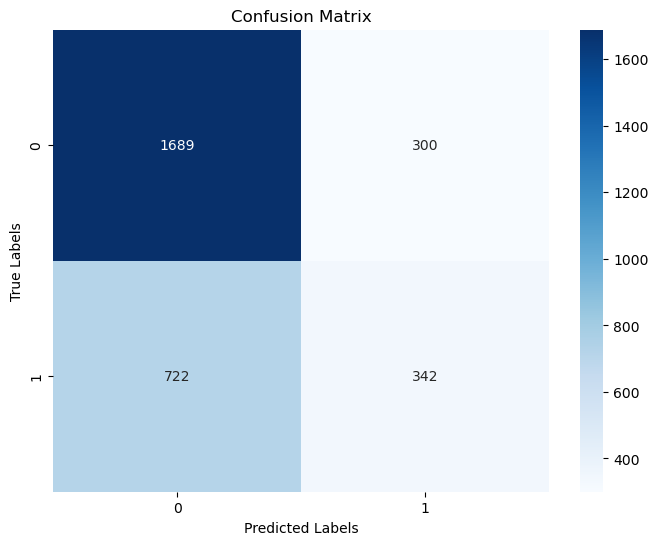

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create the confusion matrix
cm = confusion_matrix(y_test, preds)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

**What type of errors are more common for your model?**

Based on these metrics, we can conclude that the XGBoost model with Grid Search generally performs well, with high precision, recall, F1 score, and accuracy. However, if we consider the individual metrics, it appears that the model may have a slightly higher tendency to produce false negatives (miss some positive samples) compared to false positives (incorrectly predicting positive when it's actually negative).

##### **Feature importance**

Use the `plot_importance` function to inspect the top 10 most important features of your final model.

In [55]:
from xgboost import plot_importance

# Get feature importances scores from the final model
importances = xgb_cv1.best_estimator_.feature_importances_

# Convert importances into a pandas DataFrame
importances_df = pd.DataFrame({'feature':X.columns, 'importance':importances})

# Sort DataFrame by importance
importances_df = importances_df.sort_values('importance', ascending=False)

# # Plot top 10 features
# sns.barplot(x='importance', y='feature', data=importances_df.head(10))

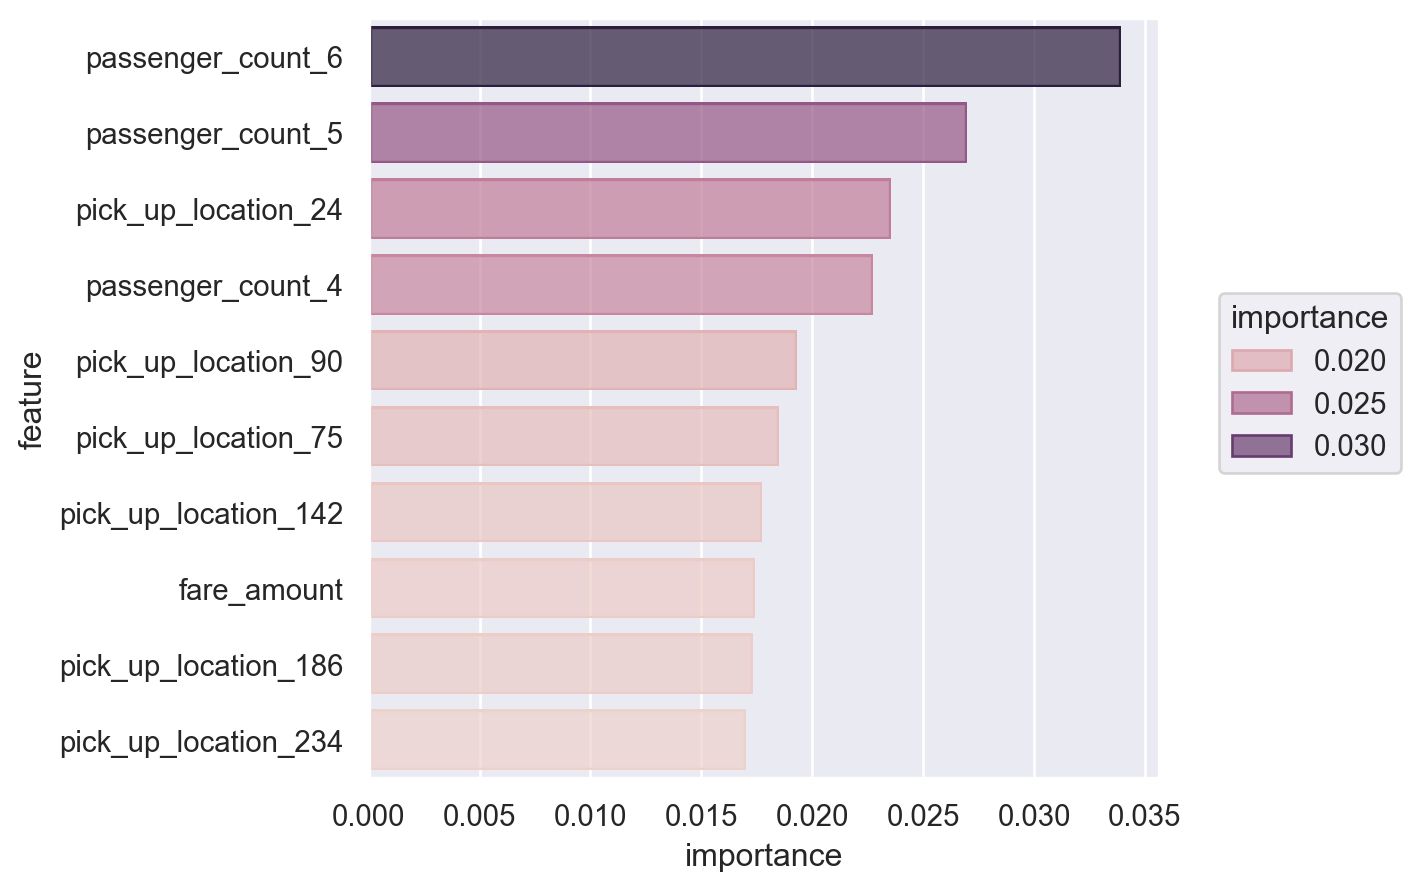

In [56]:
# Plot top 10 features
(so.Plot(data = importances_df.iloc[0:10]
         ,x = 'importance'
         ,y = 'feature'
         ,color = 'importance'
         )
 .add(so.Bar())
 )


## PACE: **Execute**

Consider the questions in your PACE Strategy Document to reflect on the Execute stage.

### **Task 4. Conclusion**

We can predict whether a customer will give tips or not with high accuracy. It is unethical to avoid customers who don't tip and also possible to mistakenly classify them as such. Going by customers who give generous tips is a far better metric and we predicted this with high accuracy. This will help the drivers target these custoemrs to gain higher returns.

XGboost is a more accurate model at 0.66 accuracy than the random forest model at 0.65 which was expected. Passenger count has revealed itself as the most valuable feature with 5 and 6 having the strongest correlation to tip amount. Pick up location and Fare amount also seem to be big factors to determine if a customer will leave a generous tip. None of our engineered features of PM rush and AM rush were able to make the top 10 predictors. An unexpected feature of importance was pick up location being more powerful predictor than nighttime, daytime, AM rush, PM rush. We could do further analysis on why particular pick up locations give more generous tips and understand possible targets for the drivers. We could create more features during engineering to reveal more insights and stronger predictors but we have a solid insight and understanding of how tips work within the company. Our machine learning model is not accurate enough to be deployed at 66% accuracy and needs some feature engineering and hyperparameter tuning to achieve an adequate accuracy of 80% +.